In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from skimage import measure, color, io
import json
import csv
from math import floor
from glob import glob
import os

In [2]:
# found lots of image values > 0 and < 255.  Fix those
def my_threshold(x):
    return 255 if x > 250 else 0

my_threshold = np.vectorize(my_threshold)

def get_labels(mask_file_name):
    mask_image = Image.open(mask_file_name).convert('L')
    mask_array = np.reshape(np.asarray(mask_image),(mask_image.height,mask_image.width))
    total_pixels = mask_image.height * mask_image.width
    # get rid of any 255,254 noise
    #mask_array = np.clip(mask_array*100.0,0,255).astype('uint8')
    mask_array = my_threshold(mask_array)
    #print(mask_array.dtype,mask_array.shape,np.min(mask_array),np.max(mask_array))
    # label individual regions
    mask_labels, num_labels = measure.label(mask_array,return_num=True,background=0.0,connectivity=2)
    #print(mask_labels.shape,num_labels)
    return total_pixels, mask_labels, num_labels

def get_rects(total_pixels,mask_labels):
    # find rectangles and return as array of tuples (x0,y0,w,h)
    regions = []
    mask_props = measure.regionprops(mask_labels)
    ave_h = 0
    num_good_labels = 0
    for i in range(num_labels):
        if mask_props[i].area > total_pixels*0.005:
            (y0,x0,y1,x1) = mask_props[i].bbox
            h = (y1-y0)
            ave_h += h
            num_good_labels += 1
    ave_h /= num_good_labels
    ave_h2 = ave_h/2
    print("good_regions = %d"%(num_good_labels))
    for i in range(num_labels):
        if mask_props[i].area > total_pixels*0.005:
            (y0,x0,y1,x1) = mask_props[i].bbox
            yc,xc = mask_props[i].centroid
            h = (y1-y0)
            h2 = h/2
            # m = 0 FIXME to deal with rotations
            regions.append((x0,int(yc-ave_h2),(x1-x0),int(ave_h),0.0,int(yc)))
    if len(regions) == 0:
        print("No good regions found")
        return []
    #if len(regions) == 1:
    #    print("Only one region.  Guessing at ave_dy")
    #    ave_dy = 3*ave_h
    #else:
    #    ave_dy = 0
    #    for i in range(len(regions)-1):
    #        (x,y,w,h,m,b) = regions[i]
    #        (_,y1,_,_,_,b1) = regions[i+1]
    #        dy = y1 - y
    #        ave_dy += dy
    #    ave_dy /= len(regions)-1
    #ave_dy2 = ave_dy/2
    #out_h2 = int(ave_dy2 * 1.5) # a little more margin is good
    out_h2 = 120/2 # need them all to have the same size
    rects = []
    for i in range(len(regions)):
        (x,y,w,h,m,b) = regions[i]
        rects.append((x,y+h//2-out_h2,w,2*out_h2))
    return rects

def get_score_image(base_name):
    score_file_name = f'../setup/{base_name}.png'
    score_image = Image.open(score_file_name)
    background = Image.new('RGBA', score_image.size, (255,255,255))
    score_image = Image.alpha_composite(background,score_image)
    score_image = score_image.convert('L')
    return score_image

def save_score_training_images(base_name,output_path,rects,training_info):
    score_image = get_score_image(base_name)
    for i,(x,y,w,h) in enumerate(rects):
        name = 'strip_score_%s_%02d.png'%(base_name,i)
        #print("%s %d %d"%(name,x,y))
        training_info.append({"base": base_name, "name": name, "x": x, "y": y, "width": w, "height": h})
        score_image.crop((x,y,x+w,y+h)).save(output_path+"/"+name) 

In [3]:
# do this once
#!mkdir data/train2

This uses the data/results/pred\_mask\_\*... files to create data/train2/ png files that are isolated 'strips' that exactly isolate a staff.  The json file also describes these strips in order to help train.

In [7]:
#base_name = 'gen_one'
training_info = []
#for base_name in ['chromatic','chromatic_piano','gen_one','gen_two','twinkle']:
for base_name in ['chromatic','twinkle','gen_one','gen_two',
                  'gen_three_1','gen_three_2','gen_three_3']:
    print(f"base_name = {base_name}")
    total_pixels, mask_labels, num_labels = get_labels(f"data/results/pred_mask_{base_name}.png")
    # going to change to use golden mask files for this...
    #total_pixels, mask_labels, num_labels = get_labels(f"../setup/{base_name}_mask.png")
    rects = get_rects(total_pixels, mask_labels)
    save_score_training_images(base_name,'data/train2',rects,training_info)
print("saving json info file.")
with open(f"data/train2/strip_score_info.json", 'w') as outfile:
    json.dump(training_info, outfile, indent = 2)

base_name = chromatic
good_regions = 1
base_name = twinkle
good_regions = 2
base_name = gen_one
good_regions = 10
base_name = gen_two
good_regions = 12
base_name = gen_three_1
good_regions = 12
base_name = gen_three_2
good_regions = 13
base_name = gen_three_3
good_regions = 11
saving json info file.


In [8]:
# save the cropped images to train the resnet
!mkdir -p data/train3
!mkdir -p data/test3
!mkdir -p data/valid3
# clean up previous runs
!rm -f data/train3/*png
!rm -f data/test3/*png
!rm -f data/valid3/*png

In [9]:
def get_notes(base_name):
    notes = []
    with open(f'../setup/{base_name}.rmfxy') as csvfile:
        for row in csv.reader(csvfile):
            if row[0] == 'note':
                notes.append(row[1:])  
    return notes

img_crop_width = 32
note_width = 7
img_step = 1 # was 4 & had overfitting.  Trying 1 just to see...
cur_base_name = None
cropped_img_index = 0

cropped_image_output_info = []

for cur_score_info in training_info:
    #print("================================================================================")
    #print("cur_score = ",cur_score_info['name'])
    if cur_base_name == None or cur_base_name != cur_score_info['base']:
        cur_base_name = cur_score_info['base']
        print(f"loading {cur_base_name}")
        notes = get_notes(cur_base_name)
        note_index = 0
    img_crop_height = cur_score_info['height']
    sent_note = False
    #cur_img =     score_file_name = f'../setup/{base_name}.png'
    cur_img = Image.open('data/train2/' + cur_score_info['name'])
    for img_x in range(0,cur_score_info['width'],img_step):
        #print(cropped_img_index,"crop",cur_score_info['name'],"to",cur_score_info['x'] + img_x,end="")
        cropped_img_name = f'data/train3/crop_score_%05d.png'%(cropped_img_index)
        cur_img.crop((img_x,                  0,
                      img_x + img_crop_width, img_crop_height)).save(cropped_img_name) 
        cropped_img_index += 1
        if note_index < len(notes):
            n = notes[note_index]
            nx = floor(float(n[3]))
            if nx <= cur_score_info['x'] + img_x + img_crop_width//2 <= nx + note_width:
                sent_note = True
                #print(":",note_index,n)
                # 67,6.000000,2.000000,316.145720,57.260594
                # note, beat, length, x, y.  Just want to save note & length at the moment
                # length=1=quarter note.  have 16th notes too.  multiply by 4
                # we need the notes from -1,0,1..127 to map to 1..130 so that we leave room
                # for the 0="none" value
                cropped_image_output_info.append([int(n[0])+2,int(float(n[2])*4)])
            else:
                #print(": no note")
                cropped_image_output_info.append([0,0])
                if sent_note:
                    sent_note = False
                    note_index += 1
        else:
            #print(": no note")
            cropped_image_output_info.append([0,0])
            
print("saved %d crop_score images"%(cropped_img_index))
print("saving json info file.")
with open(f"data/train3/crop_score_info.json", 'w') as outfile:
    json.dump(cropped_image_output_info, outfile, indent = 2)

loading chromatic
loading twinkle
loading gen_one
loading gen_two
loading gen_three_1
loading gen_three_2
loading gen_three_3
saved 44748 crop_score images
saving json info file.


In [10]:
# move files into train/validation/test dirs
all_files  = glob('data/train3/crop_score_*.png')
num_images = len(all_files)
num_valid  = int(0.2*num_images)
num_test   = int(0.2*num_images)
num_train  = num_images-num_valid-num_test
print("total=%d train=%d valid=%d test=%d"%(num_images,num_train,num_valid,num_test))
# shuffle the files & then put them into new spots on the tree
# BUT, make sure to move mask & score files 
all_files  = np.random.permutation(all_files)
for i in range(num_valid): 
    old_file = all_files[i]
    new_file = old_file.replace("train","valid")
    os.rename(old_file, new_file)
for i in range(num_valid,num_valid+num_test): 
    old_file = all_files[i]
    new_file = old_file.replace("train","test")
    os.rename(old_file, new_file)


total=44748 train=26850 valid=8949 test=8949


In [8]:
# older things...

In [9]:
# how many bins do we need for the note lengths?
ii = np.array(cropped_image_output_info)
np.histogram(ii[:,1],bins=16)

(array([12484,   288,  1216,     0,  1736,     0,     0,     0,   560,
            0,     0,     0,     0,     0,     0,   512]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.]))

In [15]:
# how many bins do we need for the notes?
ii = np.array(cropped_image_output_info)
np.histogram(ii[:,0],bins=87) # full range is 0...129 or 130 units

(array([12484,   208,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     8,     8,     8,   160,
          216,   160,   216,   176,   176,   216,   192,   216,   144,
          216,   112,   112,   216,   112,   216,   112,   112,   216,
          112,   216,   112,   216,   112,    16]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,

In [61]:
training_info[-2]

{'base': 'twinkle',
 'height': 120,
 'name': 'strip_score_twinkle_00.png',
 'width': 684,
 'x': 94,
 'y': -11}

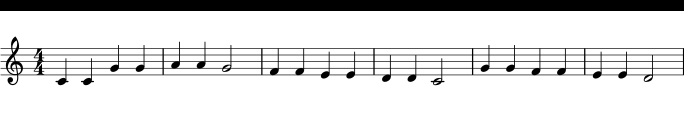

In [146]:
im = Image.open('data/train2/'+training_info[-2]['name'])
im

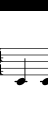

In [63]:
# first note is 
# note,60,0.000000,1.000000,151.638656,70.544111
im.crop(((151-94)-16,0,(151-94)+32,120))

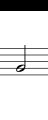

In [64]:
# 7th note is half note
#note,67,6.000000,2.000000,316.145720,57.260594
im.crop(((316-94)-16,0,(316-94)+32,120))

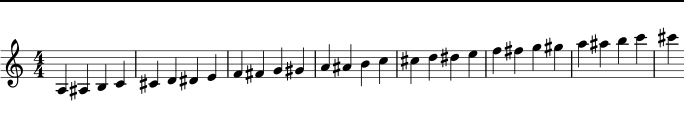

In [130]:
Image.open('data/train2/strip_score_chromatic_00.png')

In [131]:
howmany = 5
for i in range(len(cropped_image_output_info)):
    if cropped_image_output_info[i][0] > 0:
        print(i, cropped_image_output_info[i])
        howmany -= 1
        if howmany == 0:
            break
#print(i)

11 [57, 4]
12 [57, 4]
16 [58, 4]
17 [58, 4]
21 [59, 4]


In [134]:
cropped_image_output_info[1715:1720]

[[0, 0], [0, 0], [66, 2], [66, 2], [0, 0]]

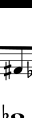

In [135]:
Image.open('data/train3/crop_score_%05d.png'%(1717))

In [5]:
# remains of earlier iterations...

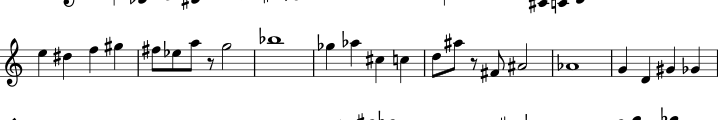

In [7]:
score_image = get_score_image('gen_two')
out_path = 'data/train'
(x,y,w,h) = rects[-1]
score_image.crop((x,y,x+w,y+h))#.save()

good_regions = 12


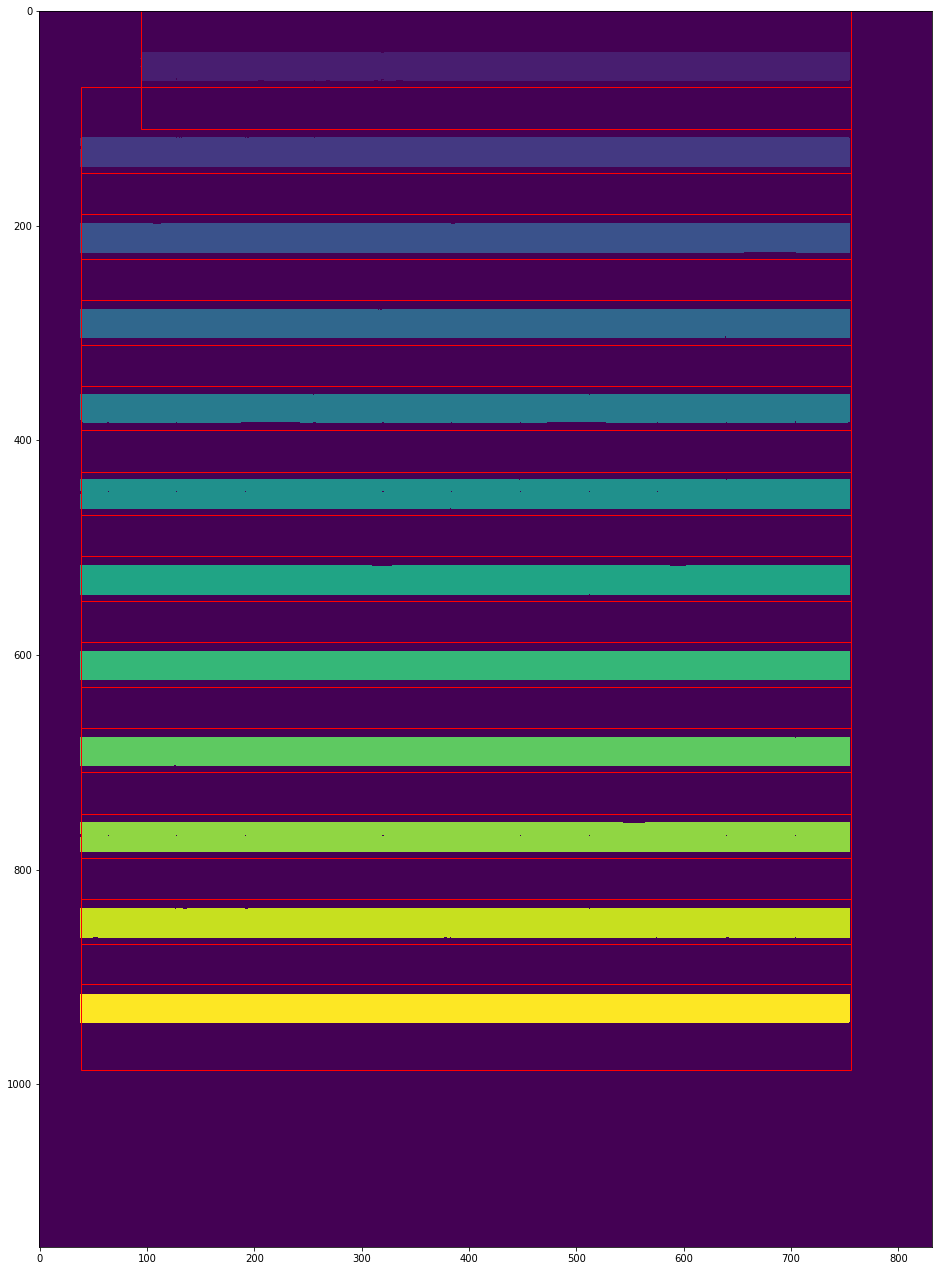

In [9]:
total_pixels, mask_labels, num_labels = get_labels(f"data/results/pred_mask_gen_two.png")
rects = get_rects(total_pixels, mask_labels)
#    
fig,ax = plt.subplots(1,figsize=(16,23))
ax.imshow(mask_labels)#,vmin=32,vmax=568) #cmap="Greys",
for (x,y,w,h) in rects:
    ax.add_patch(patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

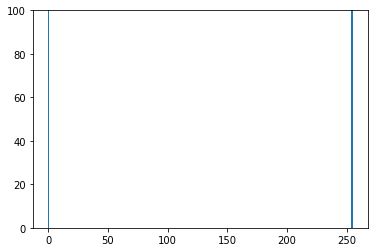

In [11]:
# playing with histograms & found had to zoom in to see spots using valuese > 0 and < 255.
# used this to create myclamp
mask_image = Image.open("data/results/pred_mask_gen_two.png").convert('L')
mask_array = np.reshape(np.asarray(mask_image),(mask_image.height*mask_image.width))
#mask_array = np.clip(mask_array*1.0,0,255).astype('uint8')
mask_array = my_threshold(mask_array)
plt.hist(mask_array,bins=256)# = mask_array*2
plt.ylim((0,100))
plt.show()

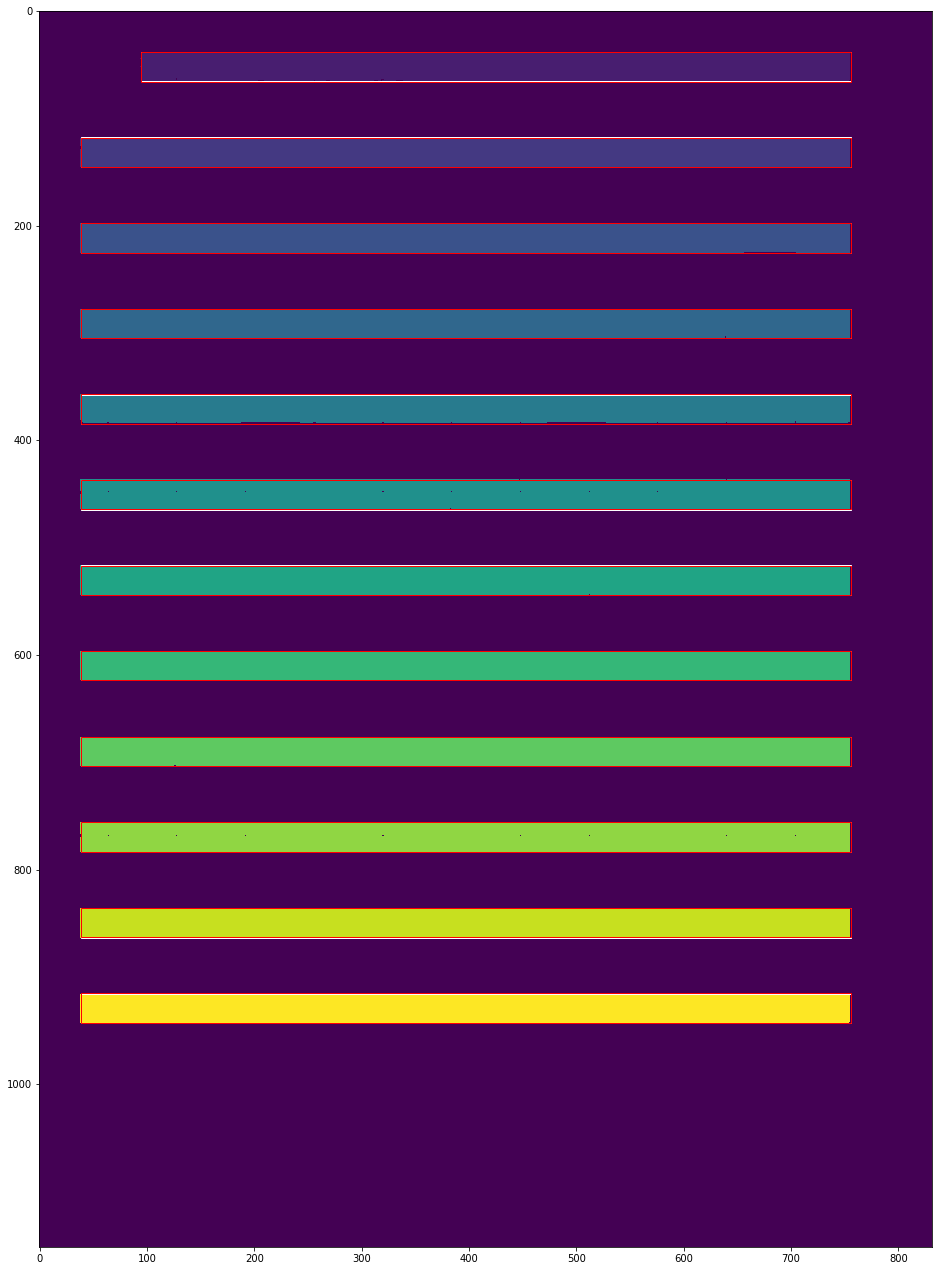

In [12]:
fig,ax = plt.subplots(1,figsize=(16,23))
ax.imshow(mask_labels)#,vmin=32,vmax=568) #cmap="Greys",
mask_props = measure.regionprops(mask_labels)
ave_h = 0
num_good_labels = 0
for i in range(num_labels):
    if mask_props[i].area > total_pixels*0.005:
        (y0,x0,y1,x1) = mask_props[i].bbox
        h = (y1-y0)
        ave_h += h
        num_good_labels += 1
ave_h /= num_good_labels
ave_h2 = ave_h/2
for i in range(num_labels):
    if mask_props[i].area > total_pixels*0.005:
        (y0,x0,y1,x1) = mask_props[i].bbox
        yc,xc = mask_props[i].centroid
        #m1,b1 = np.polyfit(mask_props[i].coords[:,0],mask_props[i].coords[:,1],1)
        #print(i,x0,y0,x1,y1,m1,b1,(y1+y0)/2)
        h = (y1-y0)
        h2 = h/2
        ax.add_patch(patches.Rectangle((x0,yc-h2),(x1-x0),h,linewidth=1,edgecolor='w',facecolor='none'))
        ax.add_patch(patches.Rectangle((x0,yc-ave_h2),(x1-x0),ave_h,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()
        